# Machine Learning Engineer Nanodegree Capstone: Pensioners among newpaper readers
## Import section

In [1]:
#!pip install scikit-plot

import warnings
warnings.filterwarnings('ignore')

#from google.colab import drive


#import sklearn
import numpy as np
import pprint as pp
import pandas as pd

from sklearn import tree, metrics
import random
import string


from imblearn.over_sampling import SMOTE, ADASYN

import xgboost as xgb
import sklearn
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression, BayesianRidge, SGDClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, r2_score, roc_curve, roc_auc_score, auc, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn import cluster
from sklearn.decomposition import PCA

#from lightgbm import LGBMClassifier

from sklearn.metrics import roc_curve, fbeta_score, make_scorer, precision_score
from sklearn.model_selection import RandomizedSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from itertools import cycle, islice
from mpl_toolkits.mplot3d import axes3d

# Agg backend runs without a display
#matplotlib.use( 'tkagg' )

In [2]:
#drive.mount('/content/drive')
#root_path = 'drive/my-drive/'
file = 'H:/Mine dokumenter/Skills/Udacity/MachineLearning/projects/Capstone/capstone.csv'
df = pd.read_csv(file,  sep=';')

display(df.head(15))

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Pensioner
0,3,22,4,5,0,0,1,4,0,0,0,0
1,13,306,14,50,0,1,2,9,1,1,0,1
2,67,228,4,56,0,2,14,31,1,1,0,0
3,3,6,0,9,0,0,1,2,3,0,1,1
4,65,545,76,134,0,3,5,51,1,1,0,1
5,0,0,0,0,0,1,12,1,1,0,0,0
6,5,172,45,16,0,0,1,6,1,1,0,0
7,39,47,2,59,0,1,1,12,2,0,1,0
8,0,59,5,8,0,1,5,1,1,1,0,0
9,26,429,28,143,0,0,1,26,2,0,0,0


# Preface

## Define constants for use in preface

In [3]:
Target = 'Pensioner'

Features = ['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7', 
            'Feature8', 'Feature9', 'Feature10', 'Feature11']

Config_Preface = {
    'scaler': RobustScaler(),
    'test_size': 0.2,
    'Stratification_limit' : 0.002,
    #'Perform_SkewFix' : False,
    'Transform_Normalize' : True, 
    'downsample': False, 
    'upsample': False
}


Config_summary = {}

if Config_Preface['Transform_Normalize']:     Config_summary[1] = 'TrnNrm=Y' 
else:                                         Config_summary[1] = 'TrnNrm=N'

if Config_Preface['downsample']:              Config_summary[2] = ',Ds=Y' 
else:                                         Config_summary[2] = ',Ds=N'

if Config_Preface['upsample']:                Config_summary[3] = ',Us=Y' 
else:                                         Config_summary[3] = ',Us=N'

# title_sub=''
# for i in range(1,3+1): title_sub = title_sub + Config_summary[i]
# print(title_sub)

## Functions for correlation matrix, normalization and transformation

In [4]:
def get_baseline(df, Target):
    
    total = float(len(df[Target]))  
    in_target = df[[Target]][df.Pensioner ==1].count()
    return float(in_target / total)




def plot_correlations(df, TargetOnly = False, Title='', size=(5,5)):
    corrmat = df.corr()
    corr_features = corrmat.index

    #sns.set(rc={'figure.figsize':(10,1)})
    plt.figure(figsize=size)
    ax = plt.axes()
    ax.set_title(Title)
    if TargetOnly:
        g = sns.heatmap(df[corr_features].corr()[-1:].T[:(len(corr_features)-1)].T,annot=True,cmap="RdYlGn", center=0, ax=ax)
    else:
        g = sns.heatmap(df[corr_features].corr()     ,annot=True,cmap="RdYlGn", center=0, ax=ax)
    #plt.figure(figsize=(20,20))

    #g = sns.heatmap(df[top_corr_features].corr(),annot=True,cmap=sns.diverging_palette(240, 10, as_cmap=True), center=0)


#show_plot_correlations(df[FEATURES + [TARGET]])


def Transform_Normalize(df):
    scaler = Config_Preface['scaler']
    
    # Fix skew
    df_Normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    #df_Normalized = pd.DataFrame(Normalizer().fit_transform(df), columns=df.columns)
    
    # Normalize
    df_Normalized_Transformed = pd.DataFrame(Normalizer().fit_transform(df_Normalized), columns=df_Normalized.columns)
    #df_Normalized_Transformed = pd.DataFrame(scaler.fit_transform(df_Normalized), columns=df_Normalized.columns)
    
    return df_Normalized_Transformed

## Baseline - % pensioners in total dataset and pr feature

Baseline: How many Pensioners in the entire dataset  0.1362126245847176


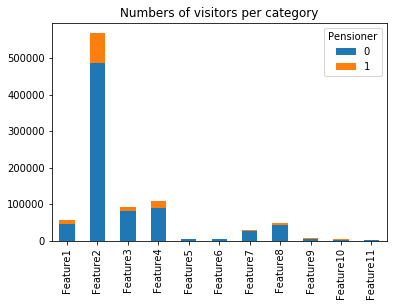

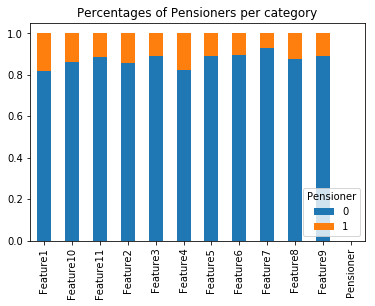

In [5]:
# Preface for entire dataset


# Illustrate level of imbalance

print('Baseline: How many Pensioners in the entire dataset ', get_baseline(df, Target))

df.groupby([Target]).sum().transpose().plot(kind='bar', stacked=True, title='Numbers of visitors per category')

(df.groupby([Target]).sum()/df.sum()).transpose().plot(kind='bar', stacked=True, title='Percentages of Pensioners per category')

## Correlation Matrix

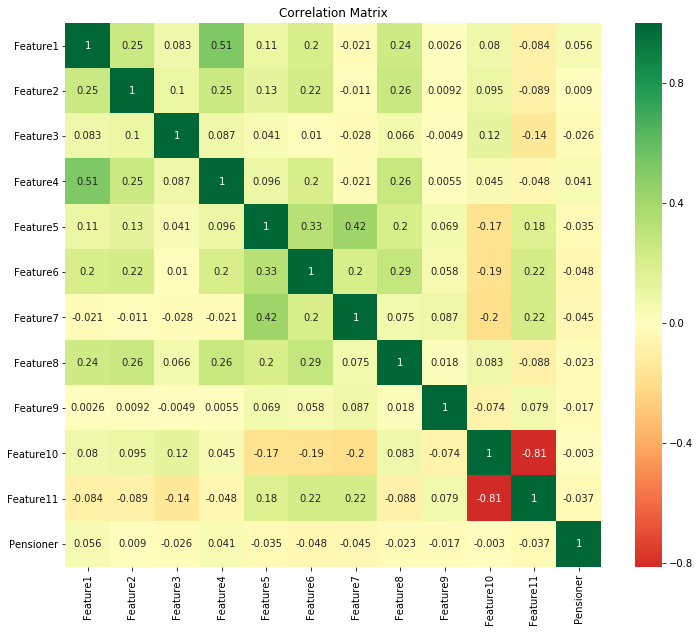

In [6]:
# Plot correlation matrix, all features and target
plot_correlations(df[Features + [Target]], TargetOnly=False, Title='Correlation Matrix', size=(12,10))

## Normalize and transform the features. Target is not altered

Config: Perform Normalization and Logarithmic transformation =  True


,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Pensioner
0,-0.133095,-0.117992,0.102381,-0.142602,0.0,0.000000,-0.221826,-0.051191,-0.665477,-0.665477,0.000000,0
1,0.170645,0.671688,0.337540,0.509323,0.0,0.365668,0.000000,0.112513,0.000000,0.000000,0.000000,1
2,0.607627,0.191804,0.022987,0.240134,0.0,0.298833,0.597666,0.298833,0.000000,0.000000,0.000000,0
3,-0.079570,-0.115687,-0.061208,-0.028418,0.0,0.000000,-0.132617,-0.091812,0.795703,-0.397851,0.397851,1
4,0.389142,0.349428,0.563165,0.434605,0.0,0.296803,0.098934,0.350075,0.000000,0.000000,0.000000,1


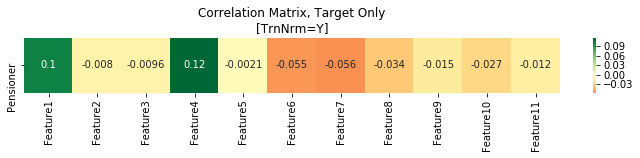

In [7]:
# Scale and transform: Dataset without classes

print('Config: Perform Normalization and Logarithmic transformation = ', Config_Preface['Transform_Normalize'])

if Config_Preface['Transform_Normalize']: 
    
    df_transformed = Transform_Normalize(df[Features])
    df_transformed[[Target]] = df[[Target]]
    
else:
    df_transformed = df

display(df_transformed.head(5))

# Plot correlation matrix, target only
title_config=''
for i in range(1,1+1): title_config = title_config + Config_summary[i]
plot_correlations(df_transformed, 
                  TargetOnly=True,  
                  Title='Correlation Matrix, Target Only' + '\n[' + title_config + ']', 
                  size=(12,1))

#display(df.head(10))

# PCA

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11
Dimension 1,-0.5885,-0.5660,-0.4794,-0.5942,-0.3054,-0.4602,-0.6276,-0.5709,-0.7230,-0.3040,0.2396
Dimension 2,0.3734,0.4402,0.8488,0.3336,-0.3162,-0.4395,-0.7058,0.2041,-0.4601,0.4463,-0.4159
Dimension 3,-0.5145,-0.4022,0.6716,-0.5083,-0.2878,-0.6721,0.7856,-0.4247,0.2964,0.1773,-0.1486
Dimension 4,-0.4112,-0.4040,0.2584,-0.4170,-0.2550,-0.2606,-0.6696,-0.4013,0.8988,-0.3357,0.3070
Dimension 5,-0.4821,-0.5077,0.5789,-0.4263,-0.4355,0.9064,0.2758,-0.2173,-0.2485,0.3053,-0.2299
Dimension 6,-0.4222,-0.4195,0.0825,-0.4150,0.9009,0.0390,-0.2632,0.4297,0.1904,0.6050,-0.5226
Dimension 7,0.2355,-0.3819,0.5725,0.3783,0.6742,0.2588,-0.1278,0.0629,-0.3513,-0.7892,0.6949
Dimension 8,0.6908,-0.8962,-0.0717,0.5321,-0.3096,-0.3117,0.1131,-0.1571,0.1236,0.3562,-0.3256
Dimension 9,-0.4602,-0.4374,-0.0271,-0.3822,-0.4922,-0.3661,-0.2422,0.9441,-0.1635,-0.3491,0.2892
Dimension 10,-0.7955,-0.2844,-0.1481,0.8731,-0.1712,-0.2101,-0.1143,-0.2127,0.0948,0.2302,-0.2418


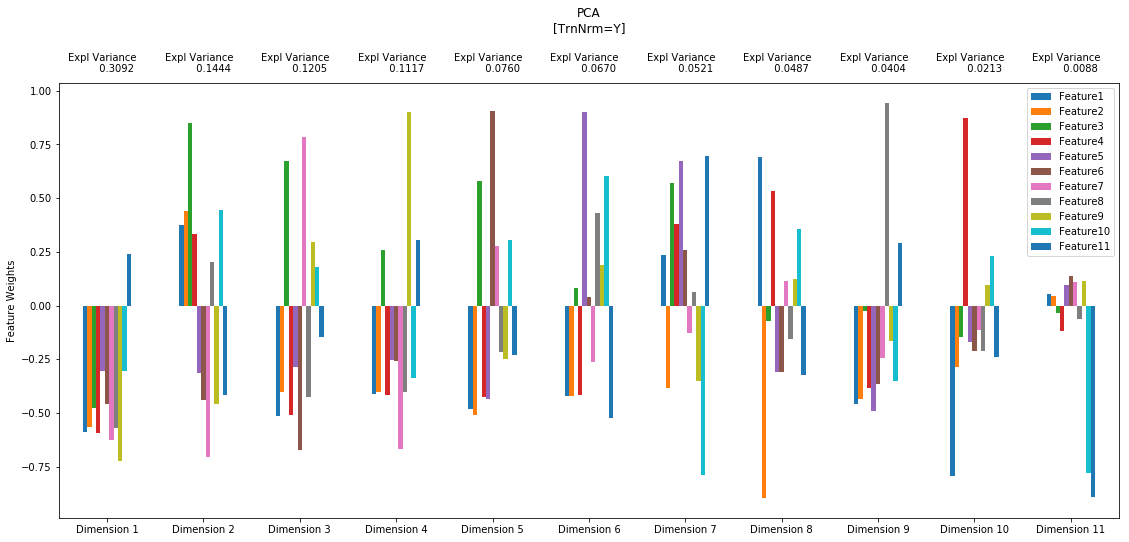

In [8]:
# Apply PCA by fitting the good data with the same number of dimensions as features

# Shop-liftet from Visuals.py for the customer_segmentation project
def pca_results(good_data, pca, scale='linear'):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    if scale=='logarithmic':
        components = pd.DataFrame(np.round(np.sign(pca.components_)*np.sqrt(np.abs(pca.components_)), 4), columns = list(good_data.keys()))
    else:
        components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
    components.index = dimensions
    display(components)

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (19,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)

    #title_config=''
    #for i in range(1,1+1): title_config = title_config + Config_summary[i]
    ax.set_title('PCA\n[' + title_config + ']\n\n\n')
    
    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Expl Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)


#print(df_LogTrans_Test.describe()) 

# Main option: PCA on oversampled, normalized and transformed data
df_PCA_sett = df_transformed[Features]

#print(PCA_sett.isnull().sum(axis = 0))

pca = PCA(n_components = df_PCA_sett.shape[1])
pca.fit(df_PCA_sett)


# Generate PCA results plot
df_pca_results = pca_results(df_PCA_sett, pca, 'logarithmic')

## Biplot - With axes from PCA

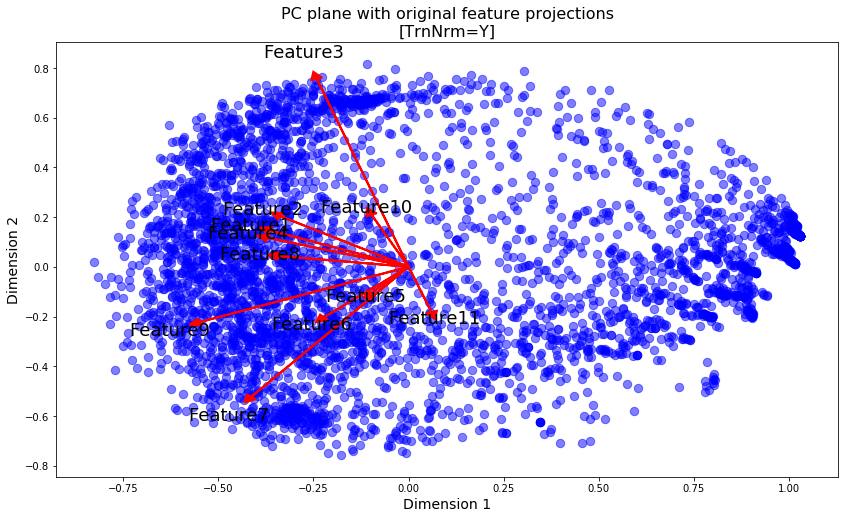

In [9]:
###########################################
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib

#import warnings
#warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")

#
# Display inline matplotlib plots with IPython

#from IPython import get_ipython
#get_ipython().run_line_magic('matplotlib', 'inline')

###########################################

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np

def biplot(good_data, reduced_data, pca):
    '''
    Produce a biplot that shows a scatterplot of the reduced
    data and the projections of the original features.
    
    good_data: original data, before transformation.
               Needs to be a pandas dataframe with valid column names
    reduced_data: the reduced data (the first two dimensions are plotted)
    pca: pca object that contains the components_ attribute

    return: a matplotlib AxesSubplot object (for any additional customization)
    
    This procedure is inspired by the script:
    https://github.com/teddyroland/python-biplot
    '''

    fig, ax = plt.subplots(figsize = (14,8))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], 
        facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    
    scaler = 0.15
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0]*scaler, arrow_size*v[1]*scaler, 
                  head_width=0.2*scaler, head_length=0.2*scaler, linewidth=2, color='red')
        ax.text(v[0]*text_pos*scaler, v[1]*text_pos*scaler, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections" + '\n[' + title_config + ']', fontsize=16);
    return ax

# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2)
pca.fit(df_PCA_sett)

# Transform using the PCA fit above
df_Transformed = pca.transform(df_PCA_sett)#[:,3:4]
#display(df_Transformed)

# Create a DataFrame for the reduced data
df_Reduced = pd.DataFrame(df_Transformed, columns = ['Dimension 1', 'Dimension 2'])

#display(df_PCA_sett.describe())
#display(df_Reduced.describe())

# Create a biplot
biplot(df_PCA_sett, df_Reduced, pca)

# Split into TEST and TRAIN datasets

In [10]:
# Split into TRAIN and TEST datasets
# Stratification

print('Baseline original dataset: ', get_baseline(df_transformed, Target))

while True:
    X_train, X_test, y_train, y_test = train_test_split(df_transformed[Features], 
                                                        df_transformed[[Target]], 
                                                        test_size=Config_Preface['test_size'])#, random_state=42)

    df_Train=X_train
    df_Train[Target] = y_train
    X_train = df_Train[Features].sort_index()
    Baseline_Train = get_baseline(df_Train, Target)
    y_train = y_train.sort_index()

    df_Test=X_test
    df_Test[Target] = y_test
    X_test = df_Test[Features].sort_index()
    Baseline_Test = get_baseline(df_Test, Target)
    y_test = y_test.sort_index()
    
    if(abs(Baseline_Train - Baseline_Test) < Config_Preface['Stratification_limit']): break
    
print('Baseline training dataset: ', get_baseline(df_Train, Target))
print('Baseline testing dataset: ', get_baseline(df_Test, Target))

print('\nX_train:', X_train.shape)
print('y_train:', y_train.shape)

print('\nX_test:', X_test.shape)
print('y_test:', y_test.shape)

#display('X_train:', X_train.head(5))
#display('y_train:', y_train.head(5))

Baseline original dataset:  0.1362126245847176
Baseline training dataset:  0.13616137644615842
Baseline testing dataset:  0.13641755634638197

X_train: (3371, 11)
y_train: (3371, 1)

X_test: (843, 11)
y_test: (843, 1)


## Downsampling
### Downsampling with unsupervised clustering DBSCAN

In [11]:
# from Udacity course: Unsupervised learning, DBSCAN, dbscan_lab_helper.py

figsize = (10,10)
#figsize_3D = (20,20)
point_size=150
point_border=0.8


def plot_dataset(dataset, xlim=(-15, 15), ylim=(-15, 15)):
    plt.figure(figsize=figsize)
    plt.scatter(dataset[:,0], dataset[:,1], s=point_size, color="#00B3E9", edgecolor='black', lw=point_border)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()
    
    
def plot_dbscan_grid(dataset, eps_values, min_samples_values,  X_column, Y_column):
    
    fig = plt.figure(figsize=(16, 20))
    plt.subplots_adjust(left=.02, right=.98, bottom=0.001, top=.96, wspace=.05,
                        hspace=0.25)


    plot_num = 1

    for i, min_samples in enumerate(min_samples_values):
        for j, eps in enumerate(eps_values):
            ax = fig.add_subplot( len(min_samples_values) , len(eps_values), plot_num)

            dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples)
            y_pred_2 = dbscan.fit_predict(dataset)

            colors = np.array(list(islice(cycle(['#df8efd', '#78c465', '#ff8e34',
                                                 '#f65e97', '#a65628', '#984ea3',
                                                 '#999999', '#e41a1c', '#dede00']),
                                          int(max(y_pred_2) + 1))))
            colors = np.append(colors, '#BECBD6')


            for point in dataset:
                circle1 = plt.Circle(point, eps, color='#666666', fill=False, zorder=0, alpha=0.3)
                ax.add_artist(circle1)

            ax.text(0, -0.03, 'Epsilon: {} \nMin_samples: {}'.format(eps, min_samples), transform=ax.transAxes, fontsize=16, va='top')
            ax.scatter(dataset[:, 0], dataset[:, 1], s=50, color=colors[y_pred_2], zorder=10, edgecolor='black', lw=0.5)


            plt.xticks(())
            plt.yticks(())
            plt.xlim(-14, 5)
            plt.ylim(-12, 7)

            plot_num = plot_num + 1

    plt.show()
    
    
def plot_clustered_dataset(dataset, y_pred, xlim=(-15, 15), ylim=(-15, 15), neighborhood=False, epsilon=0.5, X_column=0, Y_column=1):

    fig, ax = plt.subplots(figsize=figsize)
    
    colors = np.array(list(islice(cycle(['#df8efd', '#78c465', '#ff8e34',
                                     '#f65e97', '#a65628', '#984ea3',
                                     '##f62eb7', '#e41a1c', '#dede00']),
                              int(max(y_pred) + 1))))
    colors = np.append(colors, '#00ff00')
    #colors = np.append(colors, '#BECBD6')
    
    
    if neighborhood:
        for point in dataset:
            circle1 = plt.Circle([point[X_column],point[Y_column]], epsilon, color='#666666', fill=False, zorder=0, alpha=0.3)
            ax.add_artist(circle1)
    
    #display(colors)
    ax.scatter(
        dataset[:, X_column], 
        dataset[:, Y_column], 
        s=point_size, 
        color=colors[y_pred], 
        zorder=10, 
        edgecolor='black', 
        lw=point_border)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title('Outlier Removal by Downsampling (Bright green is removed)\n[' + title_config + ']\n\n\n')
    plt.show()
    
    
def plot3D_clustered_dataset(dataset, y_pred, xlim=(-15, 15), ylim=(-15, 15), zlim=(-15, 15), neighborhood=False, epsilon=0.5, X_column=0, Y_column=1, Z_column=1,angles=(0,0)):
    #fig, ax = plt.subplots(figsize=figsize, projection='3d')
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')


    
    colors = np.array(list(islice(cycle(['#df8efd', '#78c465', '#ff8e34',
                                     '#f65e97', '#a65628', '#984ea3',
                                     '#f62eb7', '#e41a1c', '#dede00']),
                              int(max(y_pred) + 1))))
    colors = np.append(colors, '#00ff00')
    #colors = np.append(colors, '#BECBD6')
    
    
    if neighborhood:
        for point in dataset:
            circle1 = plt.Circle([point[X_column],point[Y_column],point[Z_column]], epsilon, color='#666666', fill=False, zorder=0, alpha=0.3)
            ax.add_artist(circle1)
    
    #display(colors)
    ax.scatter(dataset[:, X_column], 
               dataset[:, Y_column], 
               dataset[:, Z_column], 
               s=(point_size, point_size),#*2, 3, 0.2), 
               color=colors[y_pred], 
               zorder=111, 
               edgecolor='black', 
               lw=point_border)
    # Set the view angle
    ax.view_init(angles[0], angles[1])
    
    # Set lims for X and Y
    plt.xlim(xlim)
    plt.ylim(ylim)
    #title_config=''
    #for i in range(1,1+1): title_config = title_config + Config_summary[i]
    plt.title('Outlier Removal by Downsampling (Bright green is removed)\n[' + title_config + ']\n\n\n')
    
    # Label the axes
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    plt.figure()
    plt.show()
    
    

def Dbscan_clustering(df, epsilon, min_samples,  X_column, Y_column, Z_column, showPlot=False, x_lim=(-10, 10), y_lim=(-10, 10), z_lim=(-10, 10),angles=(0,0)):
    %matplotlib inline
    
    df.index = pd.RangeIndex(len(df.index))
    
    df_array=np.asarray(df)
    #display(df)
    
    dbscan = cluster.DBSCAN(eps=epsilon, min_samples=min_samples, n_jobs=7)
    clustering_labels = dbscan.fit_predict(df_array)
    
    #display(clustering_labels.shape)
    
    df_clustering_labels=pd.DataFrame(clustering_labels,columns=['DBscan'])
    
    # Preserve TARGETs if they are labeled with -1, relabel with 0
    df_clustering_labels_old = df_clustering_labels
    df_preserveTargets = pd.concat([df, df_clustering_labels], axis=1, sort=False)
    df_preserveTargets['DBscan_product'] = df_preserveTargets[Target] * df_preserveTargets['DBscan']
    df_preserveTargets['DBscan_preserve'] = np.where(df_preserveTargets.DBscan_product==-1, 0, df_preserveTargets['DBscan'])
    #display(df_preserveTargets[df_preserveTargets['DBscan_product']==-1])
    df_clustering_labels = df_preserveTargets['DBscan_preserve']
    #display(pd.concat([df_clustering_labels_old, df_clustering_labels], axis=1, sort=False).groupby(['DBscan','DBscan_preserve']).size())
    df_clustering_labels = pd.DataFrame(df_clustering_labels).rename(columns={'DBscan_preserve': 'DBscan'})
    
    #print('\nDBscan: Distribution of samples pr labels (-1 means no label):')
    #display(df_clustering_labels.groupby(['DBscan']).size())
    
    ClusteredSamples = df_clustering_labels[df_clustering_labels.DBscan != -1].groupby(['DBscan']).size().agg('sum')
    Clusters = df_clustering_labels.agg('max')+1
    
    if showPlot==True:
        print('Number of samples not clustered (Outliers removed): ', df_clustering_labels.shape[0]-ClusteredSamples)
        print('Number of samples placed in a cluster: ', ClusteredSamples) 
        print('Number of clusters: ', Clusters[0]) 
    
    if showPlot==True: 
        # Plot 2D:
        #plot_clustered_dataset(df_array, 
        #                       clustering_labels, 
        #                       xlim=x_lim, ylim=y_lim, 
        #                       neighborhood=False, 
        #                       X_column=X_column, Y_column=Y_column)
    
        # Plot 3D:
        plot3D_clustered_dataset(df_array, 
                               clustering_labels, 
                               xlim=x_lim, ylim=y_lim, zlim=z_lim, 
                               neighborhood=False, 
                               X_column=X_column, Y_column=Y_column, Z_column=Z_column,angles=angles)
    
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.set_axis.html#pandas.DataFrame.set_axis
    new_index = df.index
    df_clustering_labels = df_clustering_labels.set_axis(labels=new_index,axis='index', inplace=False)
    
    
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
    df = pd.concat([df, df_clustering_labels], axis=1, sort=False)
    return df



# Adjust number of samples, epsilon and min_samples to allow DBSCAN to find sufficient number of clusters in the dataset
SamplesCount = df_Train.shape[0]
#SamplesCount = 2000

if Config_Preface['Transform_Normalize']: 
    epsilon=0.54
    min_samples=3
    #epsilon=0.4
    #min_samples=3
    
    spacer = 0.5
    
    angles = (10,220)
    
    # Define column for use in plot after clustering
    Primary_column   = 'Feature3'
    Secondary_column = 'Feature7'
    Tertiary_column  = 'Feature9'

else:
    epsilon=80
    min_samples=3
    #epsilon=80
    #min_samples=3
    
    spacer = 10
    
    angles = (45,40)
    
    # Define column for use in plot after clustering
    Primary_column   = 'Feature2'
    Secondary_column = 'Feature3'
    Tertiary_column  = 'Feature4'  



# Get column index, min and max values for selected columns
Primary_column_index = X_train.columns.get_loc(Primary_column)
Primary_column_min = X_train[[Primary_column]].min()[0]
Primary_column_max = X_train[[Primary_column]].max()[0]
#print('Primary_column_min=',Primary_column_min)
#print('Primary_column_max=',Primary_column_max)

Secondary_column_index = X_train.columns.get_loc(Secondary_column)
Secondary_column_min = X_train[[Secondary_column]].min()[0]
Secondary_column_max = X_train[[Secondary_column]].max()[0]
#print('Secondary_column_min=',Secondary_column_min)
#print('Secondary_column_max=',Secondary_column_max)

Tertiary_column_index = X_train.columns.get_loc(Tertiary_column)
Tertiary_column_min = X_train[[Tertiary_column]].min()[0]
Tertiary_column_max = X_train[[Tertiary_column]].max()[0]
#print('Tertiary_column_min=',Tertiary_column_min)
#print('Tertiary_column_max=',Tertiary_column_max)

if Config_Preface['downsample']:
    print('Performing downsampling by DBscan clustering')
    # Undersample by using DBSCAN cluster technique
    df_DownSampled = Dbscan_clustering(df_Train.head(SamplesCount), 
                                        epsilon, 
                                        min_samples, 
                                        X_column=Primary_column_index, 
                                        Y_column=Secondary_column_index, 
                                        Z_column=Tertiary_column_index, 
                                        showPlot=True,
                                        x_lim=(Primary_column_min-spacer, 
                                               Primary_column_max+spacer), 
                                        y_lim=(Secondary_column_min-spacer, 
                                               Secondary_column_max+spacer), 
                                        z_lim=(Tertiary_column_min-spacer, 
                                               Tertiary_column_max+spacer),
                                        angles=angles)

    df_DownSampled = df_DownSampled[df_DownSampled.DBscan != -1].drop(['DBscan'], axis=1)
    
    X_train_downsampled = df_DownSampled[Features]
    y_train_downsampled = df_DownSampled[[Target]]
else:
    print('No downsampling is performed, no outliers are removed')
    X_train_downsampled = X_train
    y_train_downsampled = y_train



print('X_train_downsampled: ', X_train_downsampled.shape)
print('y_train_downsampled: ', y_train_downsampled.shape)

title_config=''
for i in range(1,2+1): title_config = title_config + Config_summary[i]

#X_train_downsampled = df_Train[Features]
#y_train_downsampled = df_Train[[Target]]

#display(df_UnderSampled)

No downsampling is performed, no outliers are removed
X_train_downsampled:  (3371, 11)
y_train_downsampled:  (3371, 1)


## Learning Curves
### Function definitions for Learning Curves and Model Complexity

In [12]:
###########################################
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")

# https://stackoverflow.com/questions/35225369/scikit-learn-error-message-precision-and-f-score-are-ill-defined-and-being-set/51332288
# when no data points are classified as positive, precision divides by zero as it is defined as TP / (TP + FP) 
# (i.e., true positives / true and false positives). 
# The library then sets precision to 0, but issues a warning as actually the value is undefined. 
# F1 depends on precision and hence is not defined either.
# Once one are aware of this, one can choose to disable the warning with:
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################



def ModelLearning(X, y, depth_list=[1,3,6,10], title_sub=''):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing scores for each model are then plotted. """

    y = y.values.ravel()
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)
    #print(train_sizes)

    # Create the figure window
    fig = plt.figure(figsize=(10,7))
    
    # List depths to illustrate:
    depth_list = enumerate(depth_list)
 
    # Create three different models based on max_depth
    for k, depth in depth_list:

        # Create a Decision tree regressor at max_depth = depth
        regressor = DecisionTreeRegressor(max_depth = depth)
        regressor_scorer = 'r2'
        classifier = RandomForestClassifier(max_depth = depth)
        classifier_scorer = 'precision'
        
        #estimator = regressor
        #scorer = regressor_scorer
        estimator = classifier
        scorer = classifier_scorer
        #print(train_sizes)
        #display(pd.DataFrame(y, columns=['Pensioner']).groupby(['Pensioner']).size())
        

        # Calculate the training and testing scores
        sizes, train_scores, test_scores = learning_curve(estimator, X, y, \
            cv = cv, train_sizes = train_sizes, scoring = scorer)
        #print(train_scores)

        # Find the mean and standard deviation for smoothing
        train_std = np.std(train_scores, axis = 1)
        train_mean = np.mean(train_scores, axis = 1)
        test_std = np.std(test_scores, axis = 1)
        test_mean = np.mean(test_scores, axis = 1)

        # Subplot the learning curve
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
        ax.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, test_mean - test_std, \
            test_mean + test_std, alpha = 0.15, color = 'g')

        # Labels
        ax.set_title('\nRandom Forest Classifier, max_depth = %s'%(depth))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('Score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.25, 1.25])

    # Visual aesthetics
    ax.legend(bbox_to_anchor=(-0.05, 1.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Random Forest Classifier Learning Performances' + title_sub, fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()


def ModelComplexity(X, y, title_sub=''):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """

    y = y.values.ravel()
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Vary the max_depth parameter from 1 to 20
    max_depth = np.arange(1,21)
    
    # Create a Decision tree regressor at max_depth = depth
    regressor = DecisionTreeRegressor()
    regressor_scorer = 'r2'
    #classifier = GradientBoostingClassifier()
    classifier = RandomForestClassifier()
    classifier_scorer = 'precision'

    #estimator = regressor
    #scorer = regressor_scorer
    estimator = classifier
    scorer = classifier_scorer


    # Calculate the training and testing scores
    train_scores, test_scores = validation_curve(estimator, X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = scorer)

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(7, 5))
    plt.title('Random Forest Classifier Complexity Performance' + title_sub)
    plt.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
    plt.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(max_depth, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')

    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Maximum Depth')
    plt.ylabel('Score')
    plt.ylim([-0.15,1.15])
    plt.show()

### Learning curves before upsampling: Random Forest

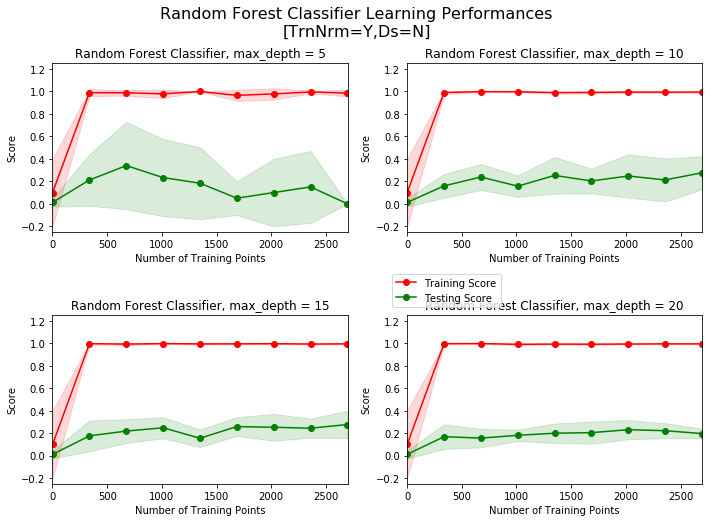

In [13]:
ModelLearning(X_train_downsampled, y_train_downsampled, depth_list=[5,10,15,20], title_sub='\n['+ title_config + ']\n\n\n')

## Upsampling with SMOTE
SMOTE was selected here. The general effect of upsampling is clear while looking at the learning curves

In [14]:

# Upsample


print('X_test before upsampling:', X_train_downsampled.shape)
print('y_test before upsampling:', y_train_downsampled.shape)
display(y_train.groupby(['Pensioner']).size())

print('Config: Perform upsampling: ', Config_Preface['upsample'])



if(Config_Preface['upsample']): 
    print('\n Performing upsampling: SMOTE \n')
    
    X_train_upsampled, y_train_upsampled = SMOTE(random_state=0).fit_resample(X_train_downsampled, y_train_downsampled.values.ravel())
    #X_train_upsampled, y_train_upsampled = ADASYN(random_state=0).fit_resample(X_train_downsampled, y_train_downsampled.values.ravel())
    
    X_train_upsampled = pd.DataFrame(X_train_upsampled, columns=Features)
    y_train_upsampled = pd.DataFrame(y_train_upsampled, columns=[Target])
else:
    print('\n No upsampling has been done \n')
    X_train_upsampled, y_train_upsampled = X_train_downsampled, y_train_downsampled
    
print('RESULT:')
print('X_test after upsampling:', X_train_upsampled.shape)
print('y_test after upsampling:', y_train_upsampled.shape)


display(y_train_upsampled.groupby(['Pensioner']).size())

title_config=''
for i in range(1,3+1): title_config = title_config + Config_summary[i]

#display(X_train_upsampled.head(10))
#display(y_train_upsampled.head(10))


X_test before upsampling: (3371, 11)
y_test before upsampling: (3371, 1)


Pensioner
0    2912
1     459
dtype: int64

Config: Perform upsampling:  False

 No upsampling has been done 

RESULT:
X_test after upsampling: (3371, 11)
y_test after upsampling: (3371, 1)


Pensioner
0    2912
1     459
dtype: int64

### Learning curves after upsampling: Random Forest and Max_Depth
Expreience: 
* With low Max_Depth, there may be a chance to reach a score=Precision just above 60% within the number of samples available in the learning dataset. 
* If a precision of >80% is expected, one need a Max_Depth well above 10, and a dataset much larger than available

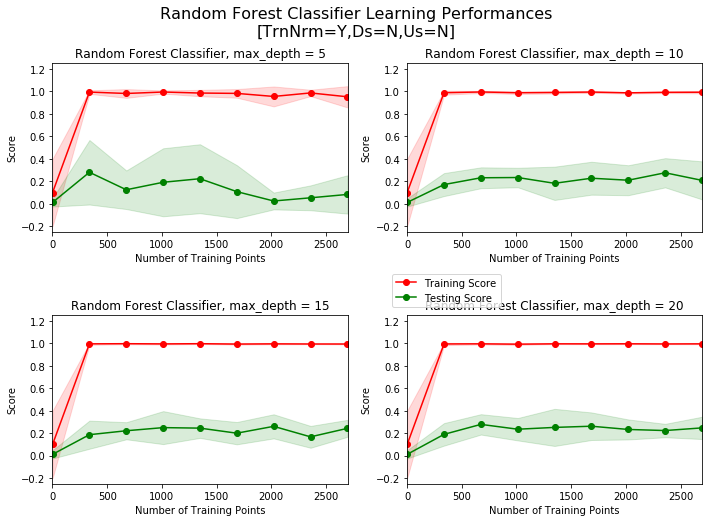

In [15]:
ModelLearning(X_train_upsampled, y_train_upsampled, depth_list=[5,10,15,20], title_sub='\n['+ title_config + ']\n\n\n')

## Learning Curves after upsampling - additional algorithms: 
## Decision Tree (Max_Depth=5) and SVM (kernel=0.001)

Automatically created module for IPython interactive environment


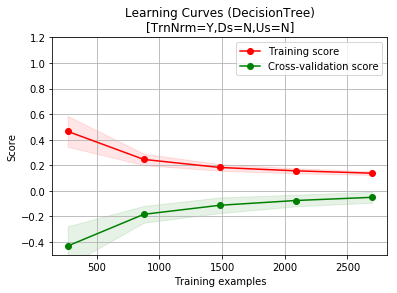

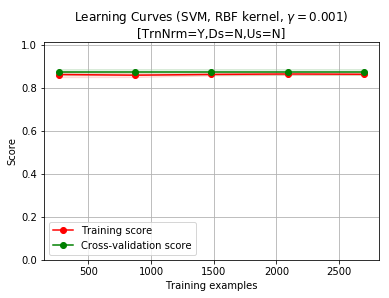

In [16]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Parameters
    ----------


    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.
  """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


digits = load_digits()
X, y = X_train_upsampled, y_train_upsampled #digits.data, digits.target


#title = "Learning Curves (Naive Bayes)"
title = "Learning Curves (DecisionTree)" + '\n['+ title_config + ']'
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

#estimator = GaussianNB()
estimator = DecisionTreeRegressor(max_depth=5)
plot_learning_curve(estimator, title, X, y, ylim=(-0.5, 1.2), cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"  + '\n['+ title_config + ']'
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0, 1.01), cv=cv, n_jobs=4)

plt.show()

### Model Complexity - before upsampling (Example algorithm: Random Forest )

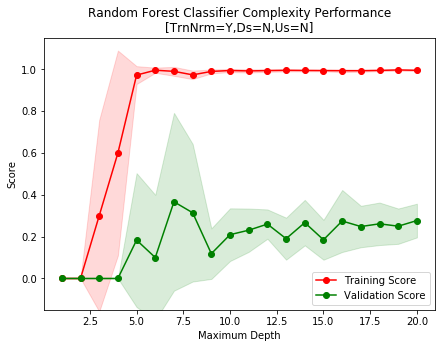

In [17]:
ModelComplexity(X_train, y_train, title_sub='\n['+ title_config + ']')

### Model Complexity - after upsampling (Example algorithm: Random Forest )
Experience:
* The dataset is not large enough to commodate a more Max_Depth of about 3 or 4. This is still 

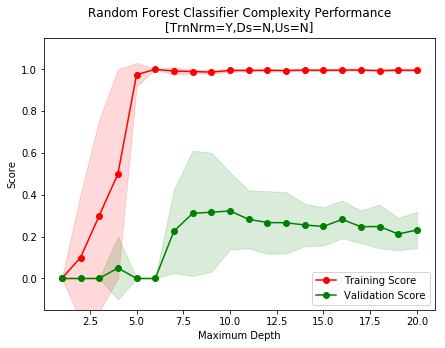

In [18]:
ModelComplexity(X_train_upsampled, y_train_upsampled, title_sub='\n['+ title_config + ']')

# Classification with different algorithms
## Function definitions

In [19]:
def report(algorithm_name,y_test, y_pred, baseline, acc_mean, acc_stddev, best_params):
    cm = confusion_matrix(y_test, y_pred)
    
    baseline_train = baseline

    # Confusion Matrix
    df_cm = pd.DataFrame(cm, columns=['negative','positive'], index=['false','true'])

    # Classification Report from sklearn.metrics
    df_cr = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

    display(df_cm)
    display(df_cr)

    # ROC area under the curve
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Precision
    p_score = float(metrics.precision_score(y_test, y_pred, average='binary'))
    
    # Recall
    r_score = float(metrics.recall_score(y_test, y_pred, average='binary'))
    
    # f_beta, beta = 0.5
    beta = Config_Classification['beta']
    
    if (r_score+p_score*beta*beta) == 0:
        f_beta=0
    else:
        f_beta = (1+beta*beta)*p_score*r_score/(r_score+p_score*beta*beta)
    
    baseline_predicted = get_baseline(pd.concat([X_train, pd.DataFrame(y_pred, columns=[Target])], axis = 1), Target)

    print('ROC AUC:', roc_auc)

    return {
    'algorithm': algorithm_name,
    'roc_auc': roc_auc,
    'precision': p_score,
    'recall': r_score,
    'f_beta': f_beta,
    'pred_base': baseline_predicted, 
    'acc_mean': acc_mean,
    'acc_stddev': acc_stddev,
    'best_params': best_params,
    'cm': df_cm,
    'cr': df_cr
    }
  
def get_accuracies(clf, X, y):
    accuracies = cross_val_score(estimator = clf, X = X, y = y, cv = Config_Classification['cv'])
    return accuracies.mean(), accuracies.std()

def preprocessing(X_train, X_test):
    scaler = CONFIG['scaler']
    fit = scaler.fit(X_train)
    X_train = fit.transform(X_train)
    X_test = fit.transform(X_test)
    #fit = Normalizer().fit(X_train)
    #X_train = fit.transform(X_train)
    #X_test = fit.transform(X_test)
    return X_train, X_test

def show_feature_importance_ExtraTreesClassifier(X, y, model, columns, title='Feature Importance (Extra Trees Classifier)'):
    model = ExtraTreesClassifier()
    model.fit(X,y)
    feat_importances = pd.Series(model.feature_importances_, index=columns)
    feat_importances.plot(kind='barh')
    plt.title(title)
    plt.show()
    plt.clf()

def plot_roc(y_proba, y_test, title=''):
    skplt.metrics.plot_roc(y_test, y_proba)
    plt.title(title)
    plt.show()
    plt.clf()

def plot_cumulative_gain(y_proba, y_test, title=''):
    skplt.metrics.plot_cumulative_gain(y_test, y_proba)
    plt.title(title)
    plt.show()
    plt.clf
    
def plot_lift_curve(y_proba, y_test, title=''):
    skplt.metrics.plot_lift_curve(y_test, y_proba)
    plt.title(title)
    plt.show()
    plt.clf
    
#def upsample(X, y):
#    return SMOTE(random_state=0).fit_sample(X, y)

In [20]:
def model(X_train, y_train, X_test, y_test, algorithm, baseline):
    #X_train = Train[Features]
    y_train = y_train.values.ravel()#Train[[Target]].values.ravel()   
    #X_test = Test[Features]
    y_test = y_test.values.ravel()#Test[[Target]].values.ravel()

    clf = algorithm


    #clf = RandomizedSearchCV(estimator = algorithm, param_distributions = PARAMS_RAND[algorithm.__class__.__name__], n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    #clf.fit(X_train, y_train)
    #display(clf.best_params_)


    if Config_Classification['tuning'] and algorithm.__class__.__name__ in PARAMS:
        clf = GridSearchCV(algorithm, 
                           PARAMS[algorithm.__class__.__name__], 
                           scoring= f05_scorer, # Config_Classification['scorer'], 
                           cv=Config_Classification['cv'], 
                           return_train_score=False, 
                           n_jobs=7) 

    clf.fit(X_train, y_train)

    show_feature_importance_ExtraTreesClassifier(X_train, y_train, clf, df[Features].columns, title='Feature Importance: ' + algorithm.__class__.__name__)

    if hasattr(clf, 'best_params_'):
        best_params = clf.best_params_
        acc_mean, acc_dev = clf.cv_results_['mean_test_score'].mean(), clf.cv_results_['std_test_score'].mean()

        #train_mean = clf.cv_results_['mean_train_score']
        #train_std = clf.cv_results_['std_train_score']

        #test_mean = clf.cv_results_['mean_test_score']
        #test_std = clf.cv_results_['std_test_score']

        #print(train_std)
        #print(test_std)

        #plt.plot(range(0,9), train_mean, label="Training score", color="black")
        #plt.plot(range(0,9), test_mean, label="Test score", color="red")


        #plot_validation_curve(train_mean, train_std, test_mean, test_std)

    else:
        best_params = {}
        acc_mean, acc_dev = get_accuracies(clf, X_test, y_test)

    display('Best parameters:', best_params)
    
    y_pred = clf.predict(X_test)
    y_pred_proba = (clf.predict_proba(X_test))

    #skplt.metrics.plot_cumulative_gain(y_test, y_pred_proba)

    plot_roc(y_pred_proba, 
             y_test, 
             title='ROC ' 
                     + algorithm.__class__.__name__ 
                     + ': AUC=' 
                     + str(int(roc_auc_score(y_test, y_pred)*1000)/1000)
                     + '\n['+ title_config + ']')
    
    
    # CUMULATIVE GAIN AND LIFT
    # https://stackoverflow.com/questions/42699243/how-to-build-a-lift-chart-a-k-a-gains-chart-in-python
    # https://buildmedia.readthedocs.org/media/pdf/scikit-plot/stable/scikit-plot.pdf
    
    # The cumulative gains and lift charts are purely for understanding how that model (and that model only) 
    # will give me more impact in a scenario where I'm not going to interact with the entire population:
    # Lift/cumulative gains charts aren't a good way to evaluate a model (as it cannot be used for comparison between models), 
    # and are instead a means of evaluating the results where your resources are finite. Either because:
    #  * there's a cost to action each result (in a marketing scenario) 
    #   * or you want to ignore a certain number of guaranteed voters, and only action those that are on the fence.
    
    
    # Generates the Cumulative Gains Plot from labels and scores/probabilities
    # The cumulative gains chart is used to determine the effectiveness of a binary classifier. 
    # A detailed explanation can be found at 
    #      http://mlwiki.org/index.php/Cumulative_Gain_Chart
    # The implementation here works only for binary classification.
    plot_cumulative_gain(y_pred_proba, 
                         y_test, 
                         title='Cumulative Gain ' + algorithm.__class__.__name__ + '\n['+ title_config + ']')
    
    # Generates the Lift Curve from labels and scores/probabilities
    # The lift curve is used to determine the effectiveness of a binary classifier. 
    #A detailed explanation can be found at 
    #      http://www2.cs.uregina.ca/~dbd/cs831/notes/lift_chart/lift_chart.html
    # The implementation here works only for binary classification.
    plot_lift_curve(y_pred_proba, y_test, title='Lift Curve ' + algorithm.__class__.__name__ + '\n['+ title_config + ']')

    _report = report(algorithm.__class__.__name__, y_test, y_pred, baseline, acc_mean, acc_dev, best_params)


    RESULTS[algorithm.__class__.__name__] = _report
    


## Parameters for GridSearch

In [25]:
RESULTS = dict()

#sorted(sklearn.metrics.SCORERS.keys())
f05_scorer = make_scorer(fbeta_score, beta=0.5)

Config_Classification = {
    #'scorer': 'roc_auc',
    #'scorer': 'f05_scorer',
    'cv': 5,
    'tuning': False,
    'beta': 0.5
}

ALGORITHMS = [GaussianNB(),
              LogisticRegression(),
              RandomForestClassifier(max_depth=3),
              XGBClassifier(max_depth=3),
              GradientBoostingClassifier(max_depth=3),
              SVC(gamma=0.001, probability=True),
              #LGBMClassifier(), 
             ]

# In case, for use in random_optimizer. Omitted for now
PARAMS_RAND = {'RandomForestClassifier':{#'bootstrap': [True, False],
                                         'max_depth': [5, 12, 13],
                                         #'max_features': ['auto', 'sqrt'],
                                         'min_samples_leaf': [1,2],
                                         'min_samples_split': [2,3,4,5],
                                         'n_estimators': [140,150,170]
                                         }
              }
# Parameters for classic grid_search
PARAMS = {'LogisticRegression':         {'penalty': ['l1', 'l2'],
                                        'C': np.logspace(0, 4, 10)
                                        },
          
          'RandomForestClassifier':     {'max_depth': [5, 10],
                                        'min_samples_split': [2],
                                        'n_estimators': [900,1000]
                                        },
          
          'XGBClassifier':              {'max_depth': [5, 10],
                                        'learning_rate': [0.01, 0.005],
                                        'n_estimators': [1000,1100],
                                        'objective': ['binary:logistic']
                                        },
          
          'GradientBoostingClassifier': {'max_depth': [5,10],
                                        'learning_rate': [0.01, 0.001],
                                        'n_estimators': [500,800,1000],
                                        },
          
#          'LGBMClassifier':             {'learning_rate': [0.01, 0.001],
#                                        'max_depth': [10,11],
#                                        'min_samples_split': [2],
#                                        'n_estimators': [1100,1200,1300]
#                                        },
         }

if Config_Classification['tuning']: Config_summary[4] = ',T=Y' 
else:                               Config_summary[4] = ',T=N'

title_config=''
for i in range(1,4+1): title_config = title_config + Config_summary[i]
#print(title_sub)

## Fit classifiers - Draw ROC kurves and present scoring

'Config dictionary:'

,0
beta,0.5
cv,5
tuning,False



---------------
GaussianNB


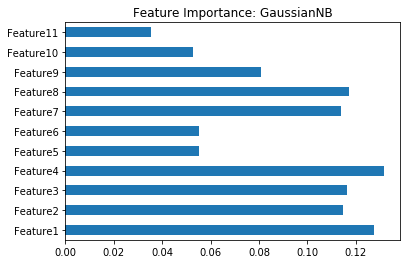

'Best parameters:'

{}

<Figure size 432x288 with 0 Axes>

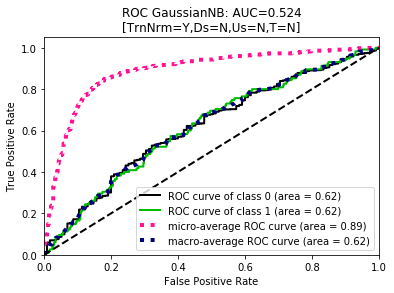

<Figure size 432x288 with 0 Axes>

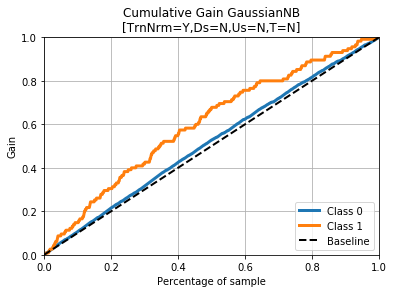

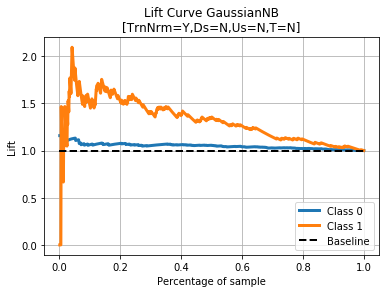

,negative,positive
false,688,40
true,103,12


,f1-score,precision,recall,support
0,0.905859,0.869785,0.945055,728.000000
1,0.143713,0.230769,0.104348,115.000000
accuracy,0.830368,0.830368,0.830368,0.830368
macro avg,0.524786,0.550277,0.524701,843.000000
weighted avg,0.801889,0.782612,0.830368,843.000000


ROC AUC: 0.5247013855709508

---------------
LogisticRegression


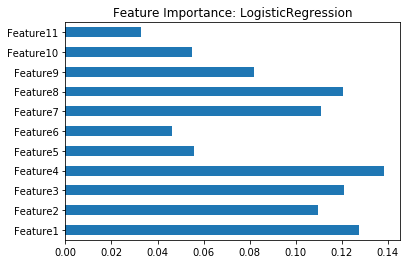

'Best parameters:'

{}

<Figure size 432x288 with 0 Axes>

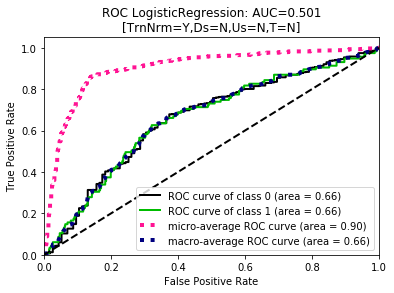

<Figure size 432x288 with 0 Axes>

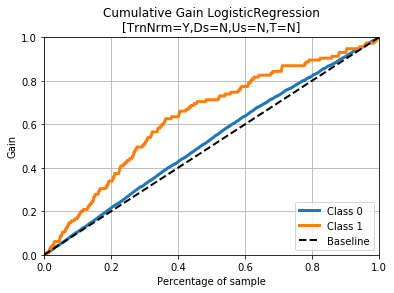

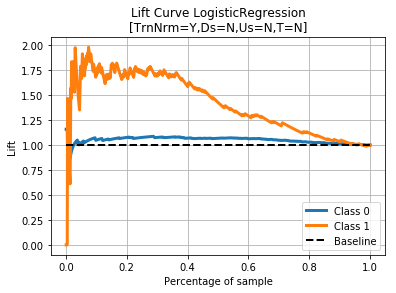

,negative,positive
false,724,4
true,114,1


,f1-score,precision,recall,support
0,0.924649,0.863962,0.994505,728.000000
1,0.016667,0.200000,0.008696,115.000000
accuracy,0.860024,0.860024,0.860024,0.860024
macro avg,0.470658,0.531981,0.501601,843.000000
weighted avg,0.800784,0.773386,0.860024,843.000000


ROC AUC: 0.5016005733397038

---------------
RandomForestClassifier


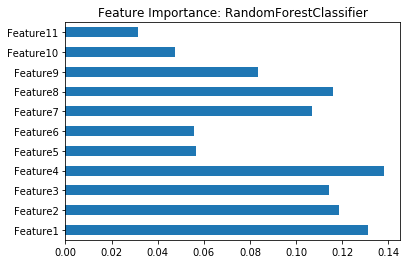

'Best parameters:'

{}

<Figure size 432x288 with 0 Axes>

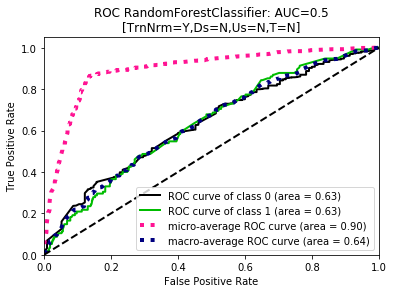

<Figure size 432x288 with 0 Axes>

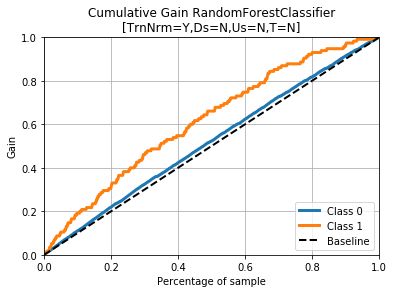

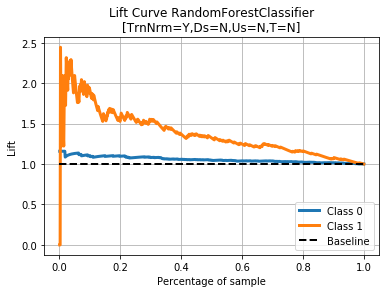

,negative,positive
false,728,0
true,115,0


,f1-score,precision,recall,support
0,0.926798,0.863582,1.000000,728.000000
1,0.000000,0.000000,0.000000,115.000000
accuracy,0.863582,0.863582,0.863582,0.863582
macro avg,0.463399,0.431791,0.500000,843.000000
weighted avg,0.800367,0.745775,0.863582,843.000000


ROC AUC: 0.5

---------------
XGBClassifier


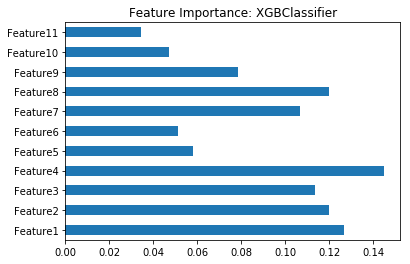

'Best parameters:'

{}

<Figure size 432x288 with 0 Axes>

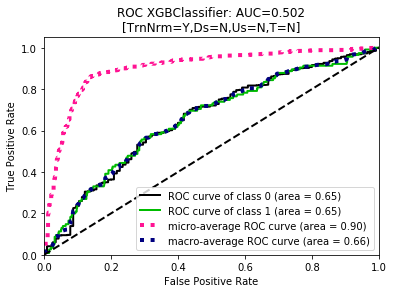

<Figure size 432x288 with 0 Axes>

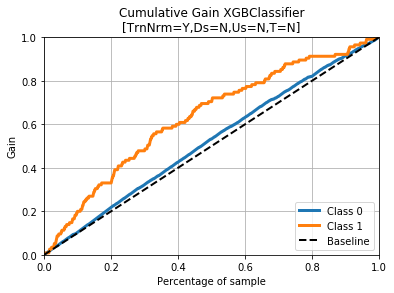

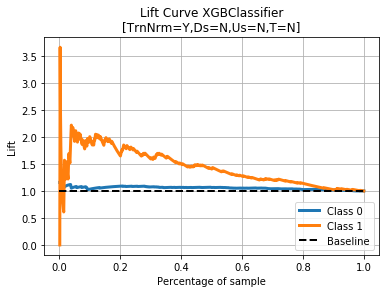

,negative,positive
false,725,3
true,114,1


,f1-score,precision,recall,support
0,0.925335,0.864124,0.995879,728.00000
1,0.016807,0.250000,0.008696,115.00000
accuracy,0.861210,0.861210,0.861210,0.86121
macro avg,0.471071,0.557062,0.502287,843.00000
weighted avg,0.801396,0.780347,0.861210,843.00000


ROC AUC: 0.5022873865265169

---------------
GradientBoostingClassifier


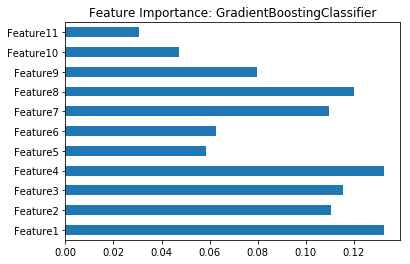

'Best parameters:'

{}

<Figure size 432x288 with 0 Axes>

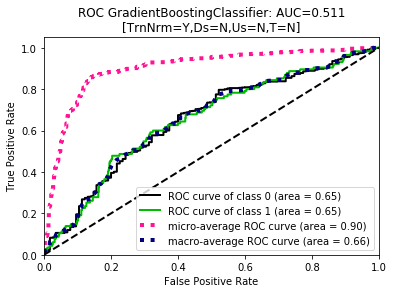

<Figure size 432x288 with 0 Axes>

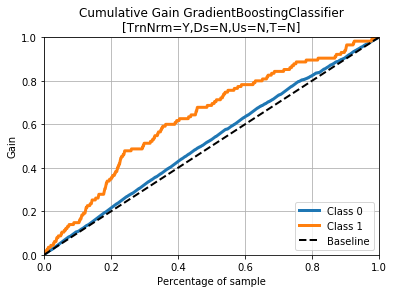

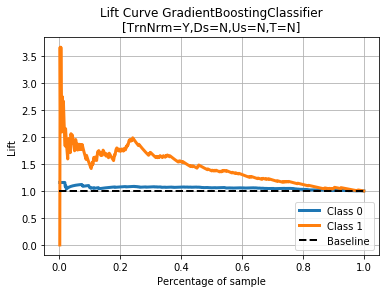

,negative,positive
false,720,8
true,111,4


,f1-score,precision,recall,support
0,0.923669,0.866426,0.989011,728.000000
1,0.062992,0.333333,0.034783,115.000000
accuracy,0.858837,0.858837,0.858837,0.858837
macro avg,0.493331,0.599880,0.511897,843.000000
weighted avg,0.806258,0.793703,0.858837,843.000000


ROC AUC: 0.5118967988533206

---------------
SVC


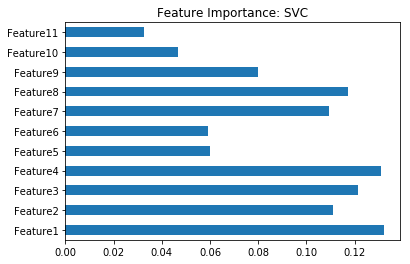

'Best parameters:'

{}

<Figure size 432x288 with 0 Axes>

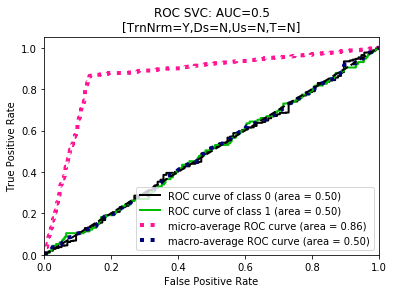

<Figure size 432x288 with 0 Axes>

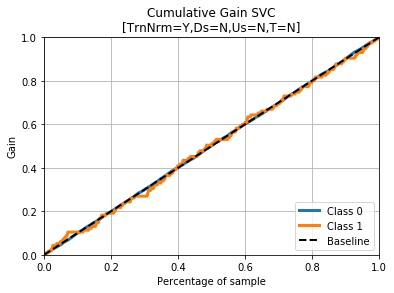

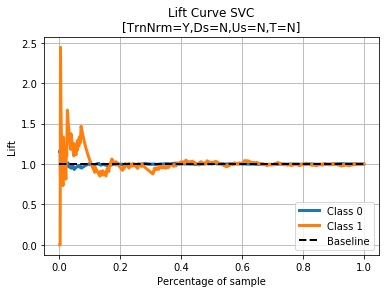

,negative,positive
false,728,0
true,115,0


,f1-score,precision,recall,support
0,0.926798,0.863582,1.000000,728.000000
1,0.000000,0.000000,0.000000,115.000000
accuracy,0.863582,0.863582,0.863582,0.863582
macro avg,0.463399,0.431791,0.500000,843.000000
weighted avg,0.800367,0.745775,0.863582,843.000000


ROC AUC: 0.5


In [26]:
display('Config dictionary:', pd.DataFrame([Config_Classification]).T)

for algorithm in ALGORITHMS:
    print()
    print("---------------")
    print(algorithm.__class__.__name__)
    model(X_train_upsampled, 
          y_train_upsampled, 
          X_test, 
          y_test, 
          algorithm = algorithm, 
          baseline=get_baseline(pd.concat([X_train_upsampled, y_train_upsampled], axis=1), Target))

# RESULTS from fitting

In [27]:
print('Model scores: \n['+ title_config + ']')
df_Metrics = pd.DataFrame.from_dict(RESULTS).drop(['algorithm','best_params','cm','cr'])

display(df_Metrics)

Model scores: 
[TrnNrm=Y,Ds=N,Us=N,T=N]


,GaussianNB,LogisticRegression,RandomForestClassifier,XGBClassifier,GradientBoostingClassifier,SVC
acc_mean,0.80429,0.863581,0.863581,0.867146,0.852888,0.863581
acc_stddev,0.0276782,0.00039686,0.00039686,0.011567,0.0122973,0.00039686
f_beta,0.185759,0.037037,0,0.0381679,0.122699,0
precision,0.230769,0.2,0,0.25,0.333333,0
pred_base,0.0146934,0.00141283,0,0.00113026,0.00339079,0
recall,0.104348,0.00869565,0,0.00869565,0.0347826,0
roc_auc,0.524701,0.501601,0.5,0.502287,0.511897,0.5


In [28]:
for algorithm in pd.DataFrame.from_dict(RESULTS):
    print()
    print("---------------")
    print(algorithm)
    
    display('Classification Report:' + '['+ title_config + ']',RESULTS[algorithm]['cr'].transpose())
    
    display('Confusion Matrix: ' + str(algorithm.__class__.__name__)  + '['+ title_config + ']',RESULTS[algorithm]['cm'].transpose())
    
    best_params = RESULTS[algorithm]['best_params']
    display('Best parameters:', pd.DataFrame([best_params]))


---------------
GaussianNB


'Classification Report:[TrnNrm=Y,Ds=N,Us=N,T=N]'

,0,1,accuracy,macro avg,weighted avg
f1-score,0.905859,0.143713,0.830368,0.524786,0.801889
precision,0.869785,0.230769,0.830368,0.550277,0.782612
recall,0.945055,0.104348,0.830368,0.524701,0.830368
support,728.000000,115.000000,0.830368,843.000000,843.000000


'Confusion Matrix: str[TrnNrm=Y,Ds=N,Us=N,T=N]'

,false,true
negative,688,103
positive,40,12


'Best parameters:'

""
0



---------------
LogisticRegression


'Classification Report:[TrnNrm=Y,Ds=N,Us=N,T=N]'

,0,1,accuracy,macro avg,weighted avg
f1-score,0.924649,0.016667,0.860024,0.470658,0.800784
precision,0.863962,0.200000,0.860024,0.531981,0.773386
recall,0.994505,0.008696,0.860024,0.501601,0.860024
support,728.000000,115.000000,0.860024,843.000000,843.000000


'Confusion Matrix: str[TrnNrm=Y,Ds=N,Us=N,T=N]'

,false,true
negative,724,114
positive,4,1


'Best parameters:'

""
0



---------------
RandomForestClassifier


'Classification Report:[TrnNrm=Y,Ds=N,Us=N,T=N]'

,0,1,accuracy,macro avg,weighted avg
f1-score,0.926798,0.0,0.863582,0.463399,0.800367
precision,0.863582,0.0,0.863582,0.431791,0.745775
recall,1.000000,0.0,0.863582,0.500000,0.863582
support,728.000000,115.0,0.863582,843.000000,843.000000


'Confusion Matrix: str[TrnNrm=Y,Ds=N,Us=N,T=N]'

,false,true
negative,728,115
positive,0,0


'Best parameters:'

""
0



---------------
XGBClassifier


'Classification Report:[TrnNrm=Y,Ds=N,Us=N,T=N]'

,0,1,accuracy,macro avg,weighted avg
f1-score,0.925335,0.016807,0.86121,0.471071,0.801396
precision,0.864124,0.250000,0.86121,0.557062,0.780347
recall,0.995879,0.008696,0.86121,0.502287,0.861210
support,728.000000,115.000000,0.86121,843.000000,843.000000


'Confusion Matrix: str[TrnNrm=Y,Ds=N,Us=N,T=N]'

,false,true
negative,725,114
positive,3,1


'Best parameters:'

""
0



---------------
GradientBoostingClassifier


'Classification Report:[TrnNrm=Y,Ds=N,Us=N,T=N]'

,0,1,accuracy,macro avg,weighted avg
f1-score,0.923669,0.062992,0.858837,0.493331,0.806258
precision,0.866426,0.333333,0.858837,0.599880,0.793703
recall,0.989011,0.034783,0.858837,0.511897,0.858837
support,728.000000,115.000000,0.858837,843.000000,843.000000


'Confusion Matrix: str[TrnNrm=Y,Ds=N,Us=N,T=N]'

,false,true
negative,720,111
positive,8,4


'Best parameters:'

""
0



---------------
SVC


'Classification Report:[TrnNrm=Y,Ds=N,Us=N,T=N]'

,0,1,accuracy,macro avg,weighted avg
f1-score,0.926798,0.0,0.863582,0.463399,0.800367
precision,0.863582,0.0,0.863582,0.431791,0.745775
recall,1.000000,0.0,0.863582,0.500000,0.863582
support,728.000000,115.0,0.863582,843.000000,843.000000


'Confusion Matrix: str[TrnNrm=Y,Ds=N,Us=N,T=N]'

,false,true
negative,728,115
positive,0,0


'Best parameters:'

""
0
